# Set-up Google Drive and Fast.ai

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai.callbacks import *
from fastai.utils import *
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

In [4]:
show_install(show_nvidia_smi = True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Sat Jun  6 11:18:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+------

# Data Manipulation

### Set paths

In [4]:
path_in = Path("/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input")
path_out = Path("/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/output")
path_mod = Path("/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/model")
path_in.ls()

[PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/jigsaw-toxic-comment-train-processed-seqlen128.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/jigsaw-toxic-comment-train.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/jigsaw-unintended-bias-train-processed-seqlen128.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/jigsaw-unintended-bias-train.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/sample_submission.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/test-processed-seqlen128.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/validation.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/validation-processed-seqlen128.csv'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/input/test.csv'),
 PosixPath('/content/gdrive/M

### Training set

In [5]:
train_df = pd.read_csv(path_in/"jigsaw-toxic-comment-train.csv")
print(len(train_df))
train_df.head()

223549


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Sample Training set (10%)

In [6]:
# Extract a sample from the whole training set.
sample_train_df = train_df[0:44500]
print(len(sample_train_df))
sample_train_df.head()

44500


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
sample_train_df.toxic.value_counts()

0    40129
1     4371
Name: toxic, dtype: int64

### Validation Set

In [8]:
valid_df = pd.read_csv(path_in/"validation.csv")
print(len(valid_df))
valid_df.head()

8000


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [9]:
print(valid_df.lang.value_counts())
print(valid_df.toxic.value_counts())

tr    3000
it    2500
es    2500
Name: lang, dtype: int64
0    6770
1    1230
Name: toxic, dtype: int64


### Test set

In [10]:
test_df = pd.read_csv(path_in/"test.csv")
print(len(test_df))
test_df.head()

63812


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [11]:
print(valid_df.lang.value_counts())

tr    3000
it    2500
es    2500
Name: lang, dtype: int64


In [13]:
print(len(train_df), len(valid_df), len(test_df)) 

223549 8000 63812


### Constructing Train DataFrame

In [12]:
train_df = pd.DataFrame([train_df.toxic, train_df.comment_text]).T
train_df.columns = ['label', 'text'] 
train_df.head()

,label,text
0,0,Explanation\nWhy the edits made under my usern...
1,0,D'aww! He matches this background colour I'm s...
2,0,"Hey man, I'm really not trying to edit war. It..."
3,0,"""\nMore\nI can't make any real suggestions on ..."
4,0,"You, sir, are my hero. Any chance you remember..."


### Constructing Validation DataFrame

In [13]:
valid_df = pd.DataFrame([valid_df.toxic, valid_df.comment_text]).T
valid_df.columns = ['label', 'text'] 
valid_df.head()

,label,text
0,0,Este usuario ni siquiera llega al rango de ...
1,0,Il testo di questa voce pare esser scopiazzato...
2,1,Vale. Sólo expongo mi pasado. Todo tiempo pasa...
3,0,Bu maddenin alt başlığı olarak uluslararası i...
4,0,Belçika nın şehirlerinin yanında ilçe ve belde...


### Constructing Test DataFrame

In [14]:
test_df = pd.DataFrame([test_df.content]).T
test_df.columns = ['text'] 
test_df.head()

,text
0,Doctor Who adlı viki başlığına 12. doctor olar...
1,"Вполне возможно, но я пока не вижу необходимо..."
2,"Quindi tu sei uno di quelli conservativi , ..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


In [0]:
train_df = train_df.dropna()
valid_df = valid_df.dropna()

### Constructing Language Model DataFrame

In [16]:
lm_df = pd.DataFrame(pd.concat([train_df.text, valid_df.text, test_df.text]))
print(len(lm_df))
print(lm_df.head())
lm_df.to_csv(path_in/"lm_text.csv", index = False)

295361
                                                text
0  Explanation\nWhy the edits made under my usern...
1  D'aww! He matches this background colour I'm s...
2  Hey man, I'm really not trying to edit war. It...
3  "\nMore\nI can't make any real suggestions on ...
4  You, sir, are my hero. Any chance you remember...


In [0]:
bs = 48

In [18]:
%%time
np.random.seed(42)
data_lm = (TextList.from_csv(path_in, "lm_text.csv", cols = 0)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs = bs))

data_lm.save(path_out/'data_lm.pkl')

CPU times: user 25.5 s, sys: 4.21 s, total: 29.7 s
Wall time: 4min 52s


In [0]:
data_lm = load_data(path_out, 'data_lm.pkl', bs = bs)

In [41]:
path_out.ls()

[PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/output/data_lm.pkl'),
 PosixPath('/content/gdrive/My Drive/JigsawToxicComments-Kaggle2020/output/data_clas_train.pkl')]

In [20]:
data_lm.show_batch()

idx,text
0,". xxmaj he seems to care more about the formatting than the actual info . xxbos "" \n xxmaj more \n i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of "" "" types of accidents "" "" xxup -i think the references may need tidying so that they are all in the"
1,"free to initiate a discussion at xxup wt : xxup football or wherever else you feel appropriate , once your block has expired . xxmaj in the meantime , if you know of other similar pages that also infringe our current guidelines , do let us know so we can clear the place up a little . xxmaj kind regards , xxmaj the xxmaj rambling xxmaj man ( talk )"
2,", i 'm not really all that into 4chan , but i did enjoy xxmaj ruby xxmaj quest and i thought that it , and the impact it had on the / tg / community was worth noting on its own page . ( or at least , the page probably needed some more work and better references ) \n \n ... xxmaj anyway , thanks again for your"
3,"resources \n xxmaj white xxmaj house circumcision petition needs signers up to and on xxup oct 23 https : / / xxunk / petitions # ! / petition / ban - non - therapeutic - routine - infant - circumcision / xxunk xxmaj routine infant circumcision is in direct violation of human rights . xxmaj it is also against the xxmaj xxunk xxmaj oath ; which states : """
4,keep 1 xxunk xxmaj xxunk keep 1 xxunk xxunk xxunk - xxmaj xxunk xxmaj xxunk keep 0 xxunk xxmaj xxunk keep 0 xxunk xxunk xxmaj xxunk keep 1 xxunk xxunk xxmaj xxunk keep 1 delete 1 xxunk xxmaj xxunk keep 1 xxunk xxmaj xxunk keep 1 delete 1 redirect \n ( mostly copied from deletion page on xxmaj farah xxmaj xxunk . ) xxmaj wikipedia requires reasonable steps to


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, model_dir = path_mod, drop_mult = 0.3, callback_fns = PeakMemMetric).to_fp16()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.20E-02
CPU times: user 56.1 s, sys: 41.7 s, total: 1min 37s
Wall time: 1min 35s


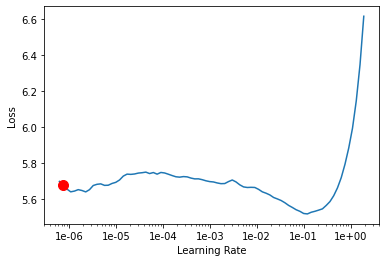

In [0]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=8)

In [0]:
learn.fit_one_cycle(2, 1E-02, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,4.190555,4.064206,0.316626,1,1,1120,2348,1:52:33


Better model found at epoch 0 with valid_loss value: 4.064206123352051.


In [22]:
learn.load(path_mod/"best_fit_head")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (265825 items)
x: LMTextList
xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types of accidents " " xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . 
 
  xxmaj there appears to be a ba

# Training Phase (+ Experimenting)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 6.31E-06
CPU times: user 23.1 s, sys: 14.1 s, total: 37.2 s
Wall time: 39.4 s


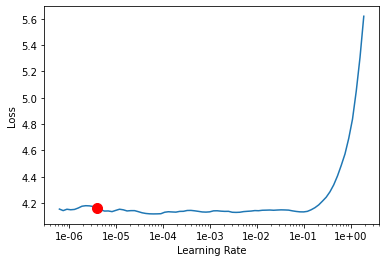

In [28]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=8)

In [29]:
learn.fit_one_cycle(1, 3E-06, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,4.028946,4.054893,0.317901,1,1,1088,2378,46:45


Better model found at epoch 0 with valid_loss value: 4.054892539978027.


In [30]:
learn.load(path_mod/"best_fit_head")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (265825 items)
x: LMTextList
xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types of accidents " " xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . 
 
  xxmaj there appears to be a ba

### Unfreezing last layers several times and iteratively training them

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 9.12E-06


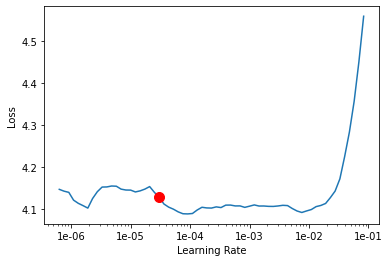

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

In [0]:
learn.fit_one_cycle(5, 2.75E-05, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_lm_fine_tuned')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,3.937614,3.876404,0.334712,1,1,770,2696,53:10
1,3.820633,3.766773,0.346283,1,1,0,2696,53:11
2,3.751855,3.722440,0.351442,1,1,0,2696,53:12


Better model found at epoch 0 with valid_loss value: 3.87640380859375.
Better model found at epoch 1 with valid_loss value: 3.766772747039795.
Better model found at epoch 2 with valid_loss value: 3.722440242767334.


In [23]:
learn.load(path_mod/'best_lm_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (265825 items)
x: LMTextList
xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types of accidents " " xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . 
 
  xxmaj there appears to be a ba

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 9.12E-06
CPU times: user 9.65 s, sys: 4.79 s, total: 14.4 s
Wall time: 17.6 s


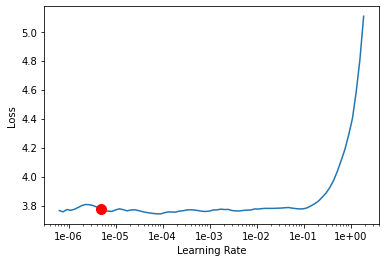

In [25]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=8)

In [26]:
learn.fit_one_cycle(2, 4E-06, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_lm_fine_tuned')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,3.607721,3.721614,0.351511,1,1,1104,2362,16:13
1,3.683884,3.721244,0.351561,1,1,0,2696,16:17


Better model found at epoch 0 with valid_loss value: 3.721613883972168.
Better model found at epoch 1 with valid_loss value: 3.7212436199188232.


In [0]:
learn.save_encoder(path_mod/"best_fine_tuned_enc")

In [24]:
%%time
bs = 128
data_clas_train =  (TextList.from_df(train_df, vocab = data_lm.vocab, cols = 1)
                    .split_none()
                    .label_from_df(cols = 0)
                    .databunch(bs = bs))

CPU times: user 21.6 s, sys: 3.94 s, total: 25.5 s
Wall time: 3min 20s


In [25]:
valid_data = TextList.from_df(valid_df, vocab = data_lm.vocab, cols = 1).split_none().label_from_df(cols = 0).databunch(bs = bs)
valid_data

TextClasDataBunch;

Train: LabelList (8000 items)
x: TextList
xxbos xxmaj este usuario ni siquiera llega al rango de xxunk . xxmaj por lo tanto debería ser xxunk en la xxunk para xxunk su alma y nuestro xxunk xxunk mediante su xxunk . xxmaj xxunk linkin 22px xxmaj honor , valor , xxunk . 17:48 13 mar 2008 ( xxup utc ),xxbos xxmaj il testo di questa voce pare esser xxunk direttamente da qui . xxmaj immagino possano esserci problemi di copyright , nel fare cio .,xxbos xxmaj vale . xxmaj sólo xxunk mi pasado . xxmaj todo tiempo pasado fue mejor , ni mucho menos , yo no quisiera xxunk 31 años a nivel particular . xxmaj las xxunk a pasar putas . xxmaj fernando,xxbos xxmaj bu maddenin alt başlığı olarak uluslararası xxunk ile konuyu xxunk ile ilgili xxunk var . xxmaj önerim siyaset bilimi ana xxunk sonra siyasal yaşam ve toplum , siyasal güç , siyasal xxunk , siyasal gruplar , çağdaş xxunk , din , siyasal xxunk , xxunk , propaganda ve siyasal xxunk temelinde xxunk siyasal xxunk . xxmaj bu al

In [0]:
data_clas_train.valid_dl = valid_data.train_dl

In [0]:
data_clas_train.save(path_out/'data_clas_train.pkl')

In [27]:
auc_roc_score = AUROC()
learn = text_classifier_learner(data_clas_train, AWD_LSTM, model_dir = path_mod, drop_mult = 0.5, metrics = [accuracy, auc_roc_score], callback_fns=PeakMemMetric).to_fp16()
learn.load_encoder(path_mod/"best_fine_tuned_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (223549 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-01
Min loss divided by 10: 7.59E-02


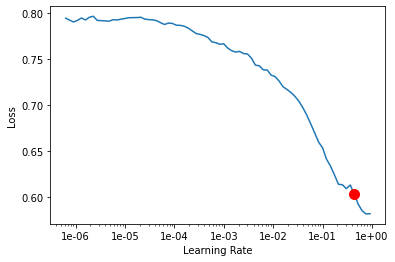

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end = 8)

In [0]:
min_grad_lr = learn.recorder.min_grad_lr

In [35]:
learn.fit_one_cycle(6, min_grad_lr, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.477650,25.616108,0.708543,0.691637,10,27,-370,5016,02:25
1,0.270492,0.870028,0.846774,0.684303,30,32,302,6352,02:45
2,0.319158,0.592027,0.851058,0.695911,10,28,-100,5324,02:35
3,0.200785,0.899601,0.810736,0.585106,10,27,0,5250,02:50
4,0.192061,1.345480,0.831653,0.670370,30,32,-200,5516,02:41
5,0.179956,0.580281,0.847404,0.724377,10,28,0,6984,02:58


Better model found at epoch 0 with valid_loss value: 25.616107940673828.
Better model found at epoch 1 with valid_loss value: 0.8700284361839294.
Better model found at epoch 2 with valid_loss value: 0.5920266509056091.
Better model found at epoch 5 with valid_loss value: 0.5802806615829468.


In [28]:
learn.load(path_mod/'best_fit_head_clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (223549 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.63E-04


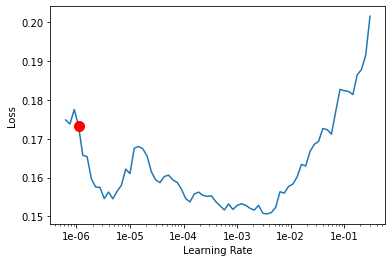

In [38]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [39]:
learn.fit_one_cycle(1, slice(1E-06, 2E-06), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'best_fit_minus2_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.166323,0.553502,0.847404,0.703836,10,28,104,6820,03:14


Better model found at epoch 0 with auroc value: 0.70383620262146.


epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.29E-07


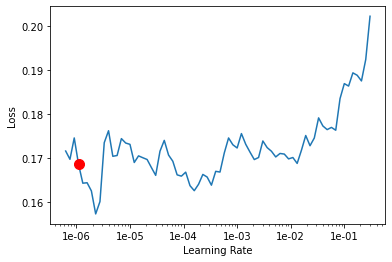

In [40]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [41]:
learn.fit_one_cycle(1, slice(1E-06, 2E-06), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'best_fit_minus2_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.181862,0.589372,0.847026,0.719920,30,32,-198,6756,03:02


Better model found at epoch 0 with auroc value: 0.719919741153717.


In [0]:
learn.save('best_fit_minus2_clas')

In [29]:
learn.load(path_mod/"best_fit_minus2_clas")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (223549 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 5.75E-07


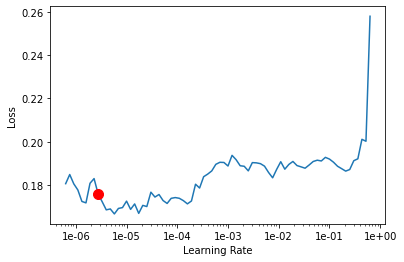

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [31]:
learn.fit_one_cycle(1, slice(1.5E-06, 2.5E-06), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'best_fit_minus2_clas')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.176189,0.587235,0.846144,0.708852,10,27,-70,5860,19:15


Better model found at epoch 0 with auroc value: 0.7088521122932434.


epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-05


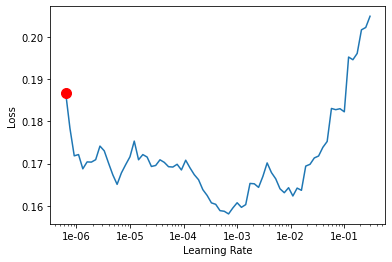

In [32]:
learn.load("best_fit_minus2_clas")
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion = True)



# Results

Although the output shows an error, it's because Google Colab session restarted. Even so, I managed to obtain an AUROC score of approx. 72%, which is OK (not great, not terrible). Although this result is decent, it definitely isn't Kaggle Competition worthy, even with what appears to be approx. 85% accuracy. I do think I might have overfitted the model, but it is quite hard to trace back, due to the computationally expensive nature of training NLP models.

In [33]:
learn.fit_one_cycle(2, slice(0.5E-04, 4E-04), moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name = 'temp')])

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.134381,0.677873,0.847782,0.723059,30,40,210,10158,38:25


Better model found at epoch 0 with auroc value: 0.7230592966079712.


KeyboardInterrupt: ignored

In [0]:
learn.save("temp")